In [1]:
# on-policy first-visit MC Control, SARSA, Q-Learning

In [2]:
import warnings ; warnings.filterwarnings('ignore')

import itertools
import gym, gym_walk, gym_aima
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [4]:
def value_iteration(P, gamma=1.0, theta=1e-10):
    V = np.zeros(len(P), dtype=np.float64)
    while True:
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64)
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
        V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi

In [5]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [6]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [7]:
def print_action_value_function(Q, 
                                optimal_Q=None, 
                                action_symbols=('<', '>'), 
                                prec=3, 
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'err')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [8]:
def probability_success(env, pi, goal_state, iterations=1000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        while not done:
            state, _, done, _ = env.step(pi(state))
        results.append(state == goal_state)
    return np.sum(results)/len(results)

In [9]:
def mean_return(env, pi, iterations=1000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        results.append(0.0)
        while not done:
            state, reward, done, _ = env.step(pi(state))
            results[-1] += reward
    return np.mean(results)

In [10]:
def regret_accumulation(env, pi, optimal_Q, iterations=10):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for i in range(iterations):
        state, done = env.reset(), False
        results.append(0.0)
        while not done:
            action = pi(state)
            regret = np.max(optimal_Q[state]) - optimal_Q[state][action]
            state, reward, done, _ = env.step(action)
            results[-1] += regret
    return np.mean(results)

In [11]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

In [12]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [13]:
def plot_value_function(title, V_track, V_true=None, log=False):
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []
    for i, state in enumerate(V_track.T):
        if not (V_true is None) and V_true[i] < 0.1:
            continue
        line_type = next(linecycler)
        label = 'Estimated V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
        if not (V_true is None):
            label = 'True v({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center left', bbox_to_anchor=(1.1+loc*0.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes')
    plt.show()

In [14]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, t):
    decay_steps = int(max_steps * decay_ratio) - 2
    rem_steps = max_steps - decay_steps - 2
    values = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
    values = values * (init_value - min_value) + min_value   
    values = np.hstack((init_value, values, min_value)) 
    values = np.pad(values, (0, rem_steps), 'edge')
    return values[t]

In [15]:
env = gym.make('SlipperyWalkSeven-v0')
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P, 0.99)
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='Optimal action-value function:')
print()

print_policy(optimal_pi, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%. Obtains an average undiscounted return of {:.4f}.'.format(
    probability_success(env, optimal_pi, goal_state=8)*100, 
    mean_return(env, optimal_pi)))

Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |

Optimal action-value function:
╒═════╤════════╤════════╕
│   s │      < │      > │
╞═════╪════════╪════════╡
│   0 │ 0      │ 0      │
├─────┼────────┼────────┤
│   1 │ 0.3119 │ 0.5637 │
├─────┼────────┼────────┤
│   2 │ 0.6703 │ 0.763  │
├─────┼────────┼────────┤
│   3 │ 0.8032 │ 0.8449 │
├─────┼────────┼────────┤
│   4 │ 0.8638 │ 0.8892 │
├─────┼────────┼────────┤
│   5 │ 0.9014 │ 0.922  │
├─────┼────────┼────────┤
│   6 │ 0.9322 │ 0.9515 │
├─────┼────────┼────────┤
│   7 │ 0.9613 │ 0.9806 │
├─────┼────────┼────────┤
│   8 │ 0      │ 0      │
╘═════╧════════╧════════╛

Policy:
|           | 01      > | 02      > | 03      > | 04      > | 05      > | 06      > | 07      > |           |
Reaches goal 97.90%. Obtains an average undiscounted return of 0.9790.


# MC Control

In [16]:
def generate_episode(pi, env, max_steps=20):
    done, episode = False, []
    while not done:
        state = env.reset()
        for t in count():
            action = pi(state) 
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward, next_state, done))
            if done:
                break
            if t >= max_steps - 1:
                episode = []
                break
            state = next_state
    return np.array(episode, np.object)

In [17]:
class ESoftPolicy:
    def __init__(self, nS, nA, epsilon=0.2):
        self.nA = nA
        self.nS = nS
        self.epsilon = epsilon
        self.probs = np.random.dirichlet(np.ones(self.nA), size=self.nS)
        for state in range(self.nS):
            action = np.random.randint(self.nA)
            self.adjust_probs(state, action, epsilon)

    def __getitem__(self, state):
        return np.random.choice(self.nA, p=self.probs[state])

    def __call__(self, state):
        return np.random.choice(self.nA, p=self.probs[state])

    def adjust_probs(self, state, best_action, epsilon):
        self.epsilon = epsilon
        prob_best = 1 - self.epsilon + self.epsilon/self.nA
        prob_other = self.epsilon/self.nA
        new_probs = [prob_other,] * (self.nA - 1)
        new_probs.insert(best_action, prob_best)
        self.probs[state] = new_probs

In [18]:
def on_policy_mc_control(env,
                         gamma=1.0,
                         init_alpha=0.5,
                         min_alpha=0.01,
                         alpha_decay_ratio=0.3,
                         init_epsilon=1.0,
                         min_epsilon=0.1,
                         epsilon_decay_ratio=0.9,
                         n_episodes=5000,
                         max_steps=100):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    nS, nA = env.observation_space.n, env.action_space.n
    discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False)    
    pi_track = []
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    pi = ESoftPolicy(nS, nA, init_epsilon)

    for t in tqdm(range(n_episodes)):
        alpha = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes, t)
        epsilon = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes, t)        
        episode = generate_episode(pi, env, max_steps)
        return_visited = np.zeros((nS, nA), dtype=bool)
        for step_idx, (state, action, reward, _, _) in enumerate(episode):
            if return_visited[state][action]:
                continue
            return_visited[state][action] = True
            
            seq_len = len(episode[step_idx:])
            G = np.sum(discounts[:seq_len] * episode[step_idx:, 2])
            Q[state][action] = Q[state][action] + alpha * (G - Q[state][action])

        Q_track[t] = Q
        pi_track.append(np.argmax(Q, axis=1))

        _, uidxs = np.unique(episode[:,0], return_index=True)
        for idx in uidxs:
            state, action, reward, _, _ = episode[idx]
            best_action = np.argmax(Q[state])
            pi.adjust_probs(state, best_action, epsilon)

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [19]:
Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = on_policy_mc_control(env, gamma=0.99)

In [20]:
print_state_value_function(V_mc, P, n_cols=9, prec=4, title='State-value function found by MC:')
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=9, prec=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='MC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_mc, goal_state=8)*100))

State-value function found by MC:
|           | 01 0.5373 | 02  0.722 | 03 0.8264 | 04 0.8772 | 05 0.9175 | 06 0.9499 | 07  0.981 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01 -0.0264 | 02 -0.041 | 03 -0.0185 | 04 -0.0121 | 05 -0.0045 | 06 -0.0016 | 07 0.0004 |           |
State-value function RMSE: 0.0179

MC action-value function:
╒═════╤════════╤════════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      > │    * < │    * > │   err < │   err > │
╞═════╪════════╪════════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0      │ 0      │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.2294 │ 0.5373 │ 0.3119 │ 0.5637 │  0.0825 │  0.0264 │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.6243 │ 0.722  │ 0.6703 │ 0.763  │  0.046  │  0.041  │

# SARSA

In [21]:
def sarsa(env,
          gamma=1.0,
          init_alpha=0.5,
          min_alpha=0.01,
          alpha_decay_ratio=0.3,
          init_epsilon=1.0,
          min_epsilon=0.1,
          epsilon_decay_ratio=0.9,
          n_episodes=5000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for t in tqdm(range(n_episodes)):
        alpha = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes, t)
        epsilon = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes, t)   
        state, done = env.reset(), False
        action = select_action(state, Q, epsilon)
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilon)
            td_estimate = reward + gamma * Q[next_state][next_action] * (not done)
            td_error = td_estimate - Q[state][action]
            Q[state][action] = Q[state][action] + alpha * td_error
            state, action = next_state, next_action
        Q_track[t] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [22]:
Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env)

In [23]:
print_state_value_function(V_sarsa, P, n_cols=9, prec=4, title='State-value function found by SARSA:')
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=9, prec=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='SARSA action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_sarsa, goal_state=8)*100))

State-value function found by SARSA:
|           | 01   0.55 | 02 0.7935 | 03 0.9272 | 04 0.9666 | 05 0.9887 | 06 0.9953 | 07  0.999 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01 -0.0137 | 02 0.0305 | 03 0.0823 | 04 0.0773 | 05 0.0667 | 06 0.0437 | 07 0.0183 |           |
State-value function RMSE: 0.0478

SARSA action-value function:
╒═════╤════════╤════════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      > │    * < │    * > │   err < │   err > │
╞═════╪════════╪════════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0      │ 0      │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.2204 │ 0.55   │ 0.3119 │ 0.5637 │  0.0915 │  0.0137 │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.5994 │ 0.7935 │ 0.6703 │ 0.763  │  0.0709 │ -0.0305

# Q-Learning

In [24]:
def q_learning(env, 
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.3,
               init_epsilon=1.0,
               min_epsilon=0.1,
               epsilon_decay_ratio=0.9,
               n_episodes=5000):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    for t in tqdm(range(n_episodes)):
        alpha = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes, t)
        epsilon = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes, t) 
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilon)
            next_state, reward, done, _ = env.step(action)
            td_estimate = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_estimate - Q[state][action]
            Q[state][action] = Q[state][action] + alpha * td_error
            state = next_state

        Q_track[t] = Q
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, pi_track

In [25]:
Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env, gamma=0.99)

In [26]:
print_state_value_function(V_ql, P, n_cols=9, prec=4, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=9, prec=4, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=9, prec=4, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql, 
                            optimal_Q, 
                            action_symbols=('<', '>'), 
                            prec=4, 
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=('<', '>'), n_cols=9)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_ql, goal_state=8)*100))

State-value function found by Q-learning:
|           | 01 0.5589 | 02 0.7534 | 03 0.8449 | 04 0.8889 | 05 0.9225 | 06 0.9536 | 07  0.984 |           |
Optimal state-value function:
|           | 01 0.5637 | 02  0.763 | 03 0.8449 | 04 0.8892 | 05  0.922 | 06 0.9515 | 07 0.9806 |           |
State-value function errors:
|           | 01 -0.0048 | 02 -0.0096 | 03   -0.0 | 04 -0.0004 | 05 0.0005 | 06 0.0021 | 07 0.0034 |           |
State-value function RMSE: 0.0038

Q-learning action-value function:
╒═════╤════════╤════════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      > │    * < │    * > │   err < │   err > │
╞═════╪════════╪════════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0      │ 0      │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.3086 │ 0.5589 │ 0.3119 │ 0.5637 │  0.0033 │  0.0048 │
├─────┼────────┼────────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.6701 │ 0.7534 │ 0.6703 │ 0.763  │  0.00

# Comparison of max(Q) for every episode

## Monte-Carlo

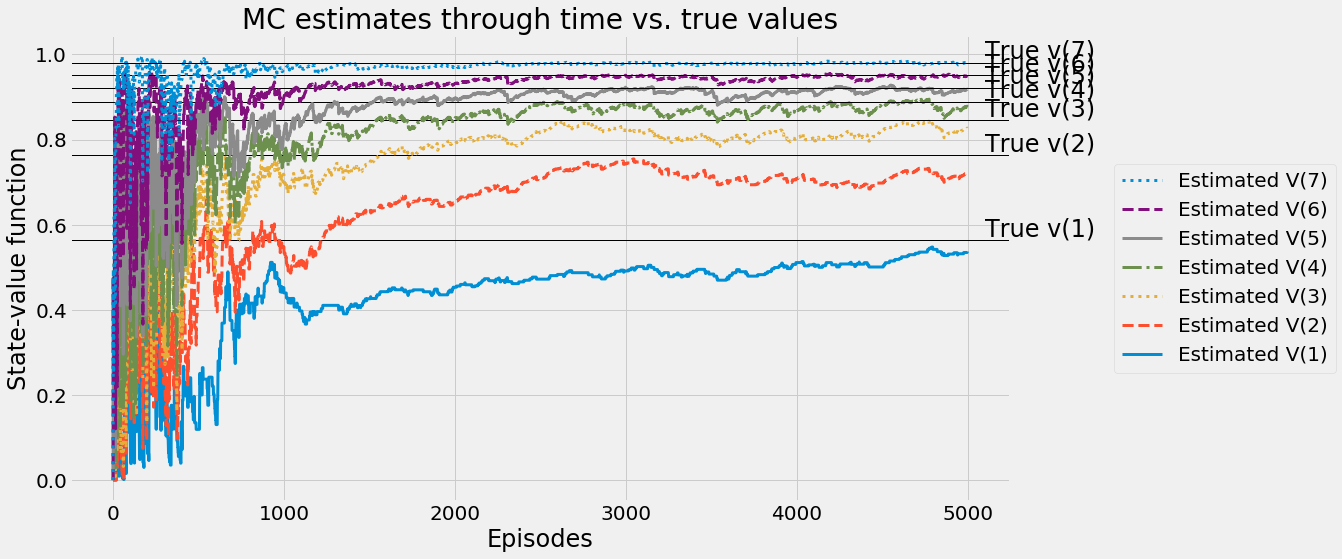

In [27]:
plot_value_function(
    'MC estimates through time vs. true values', 
    np.max(Q_track_mc, axis=2), 
    optimal_V, 
    log=False)

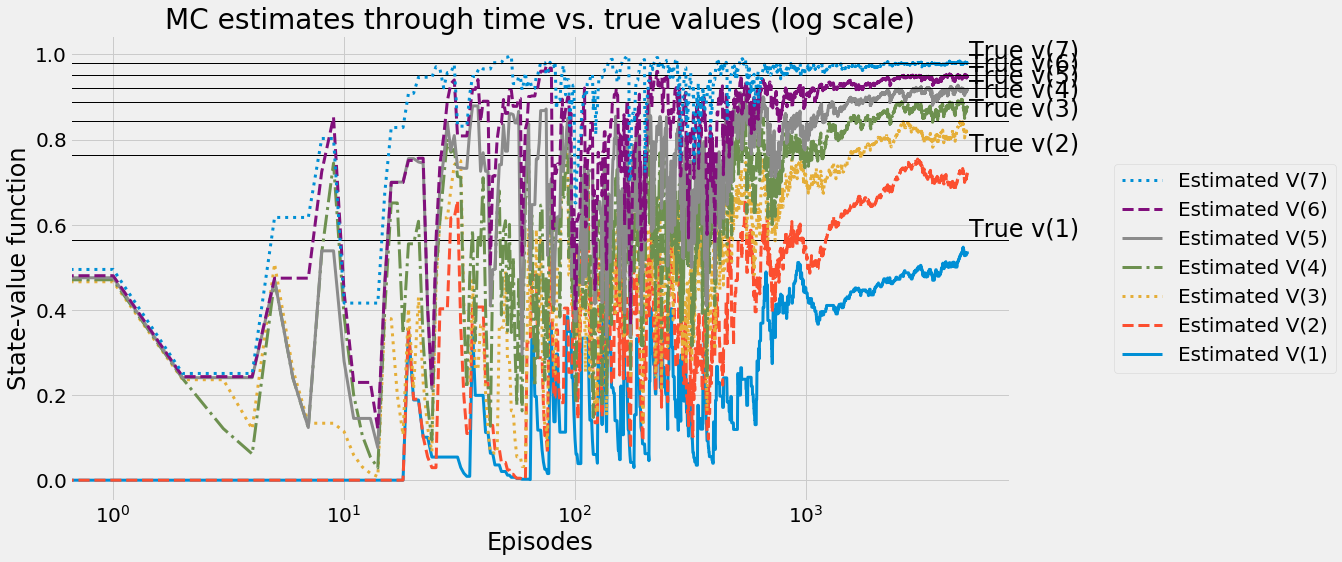

In [28]:
plot_value_function(
    'MC estimates through time vs. true values (log scale)', 
    np.max(Q_track_mc, axis=2), 
    optimal_V, 
    log=True)

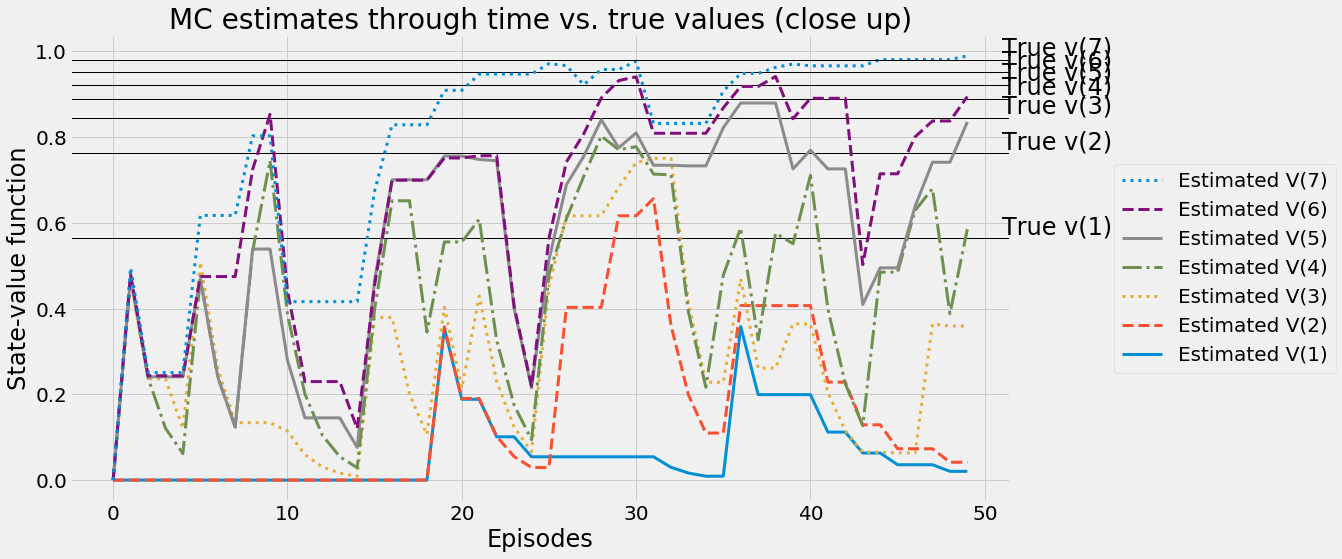

In [29]:
plot_value_function(
    'MC estimates through time vs. true values (close up)', 
    np.max(Q_track_mc, axis=2)[:50], 
    optimal_V[:50],
    log=False)

## SARSA

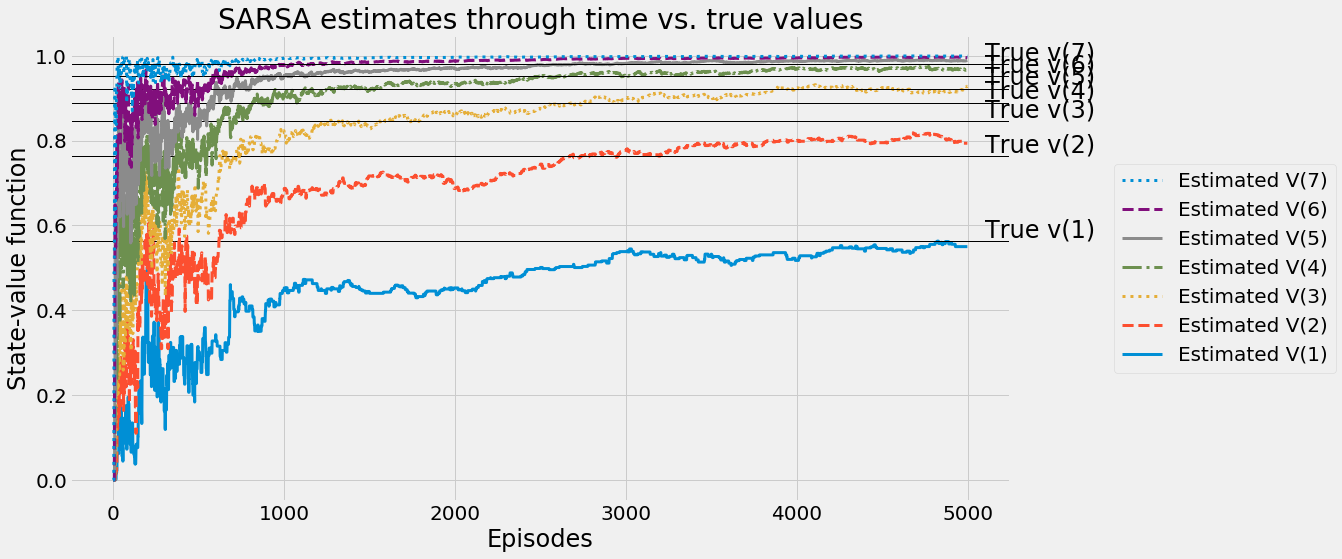

In [30]:
plot_value_function(
    'SARSA estimates through time vs. true values', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V, 
    log=False)

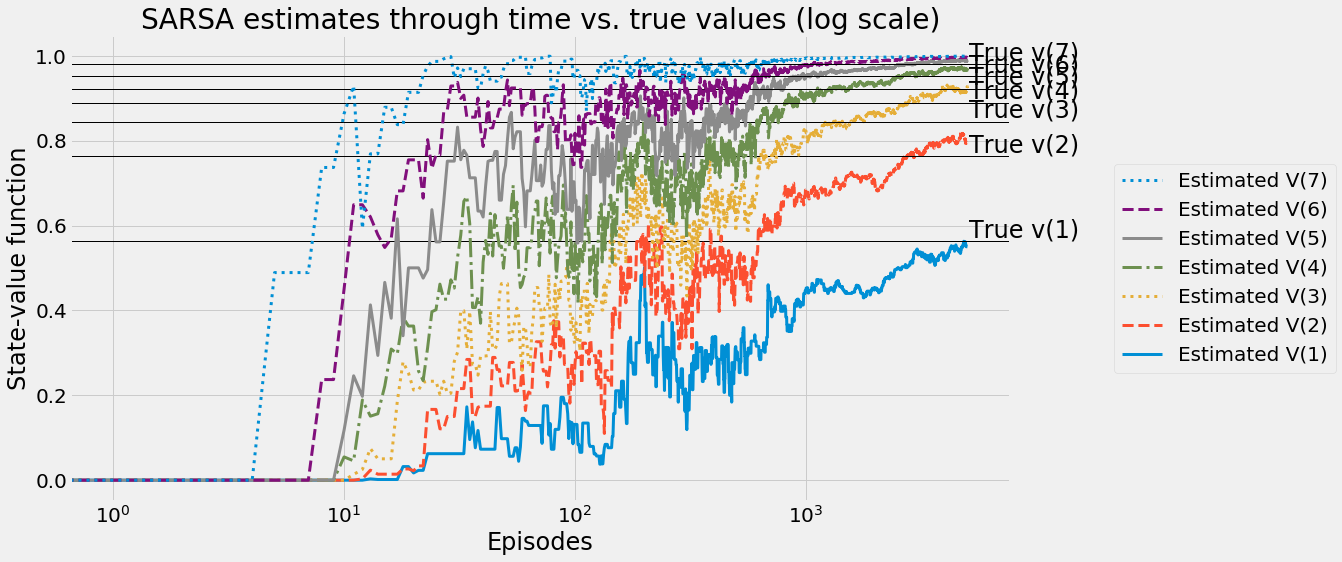

In [31]:
plot_value_function(
    'SARSA estimates through time vs. true values (log scale)', 
    np.max(Q_track_sarsa, axis=2), 
    optimal_V, 
    log=True)

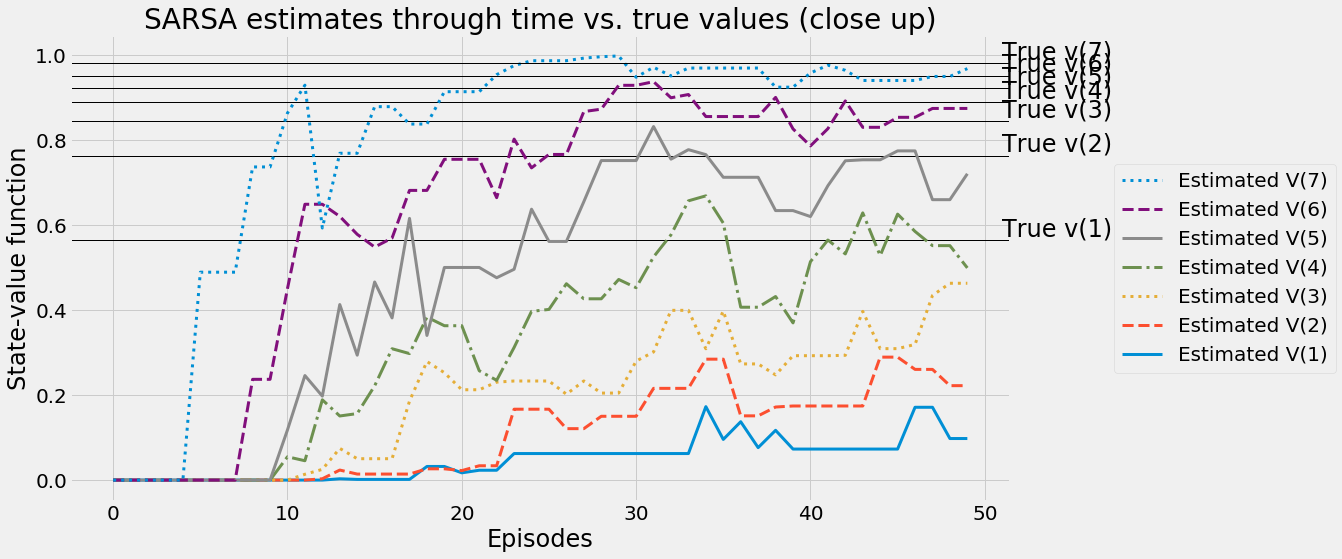

In [32]:
plot_value_function(
    'SARSA estimates through time vs. true values (close up)', 
    np.max(Q_track_sarsa, axis=2)[:50], 
    optimal_V[:50],
    log=False)

## Q-learning

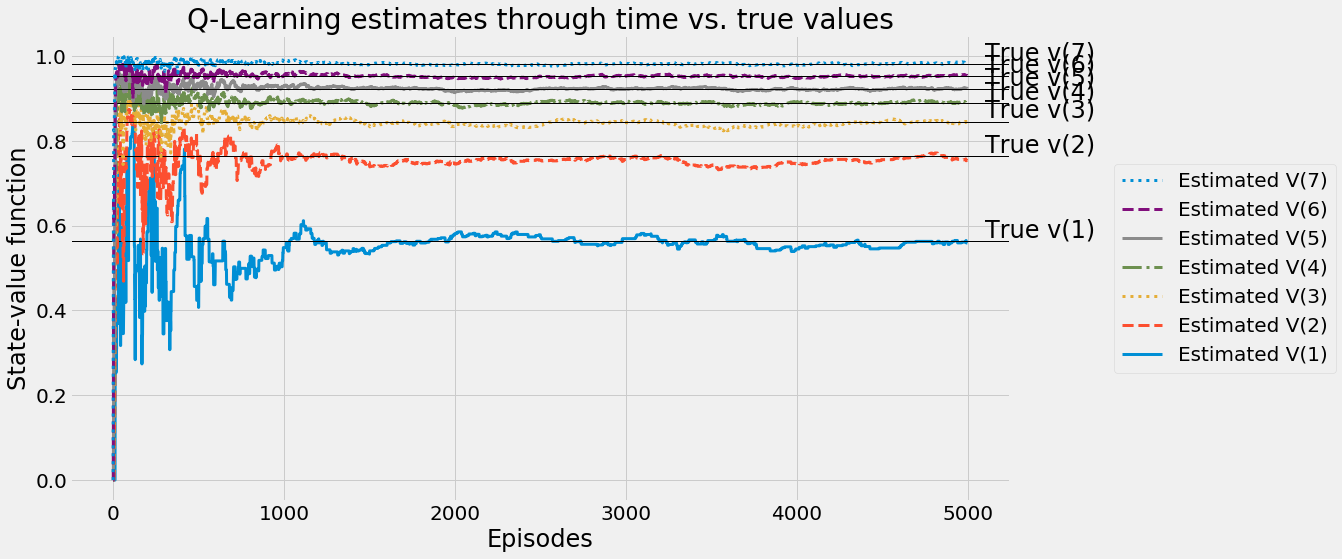

In [33]:
plot_value_function(
    'Q-Learning estimates through time vs. true values', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    log=False)

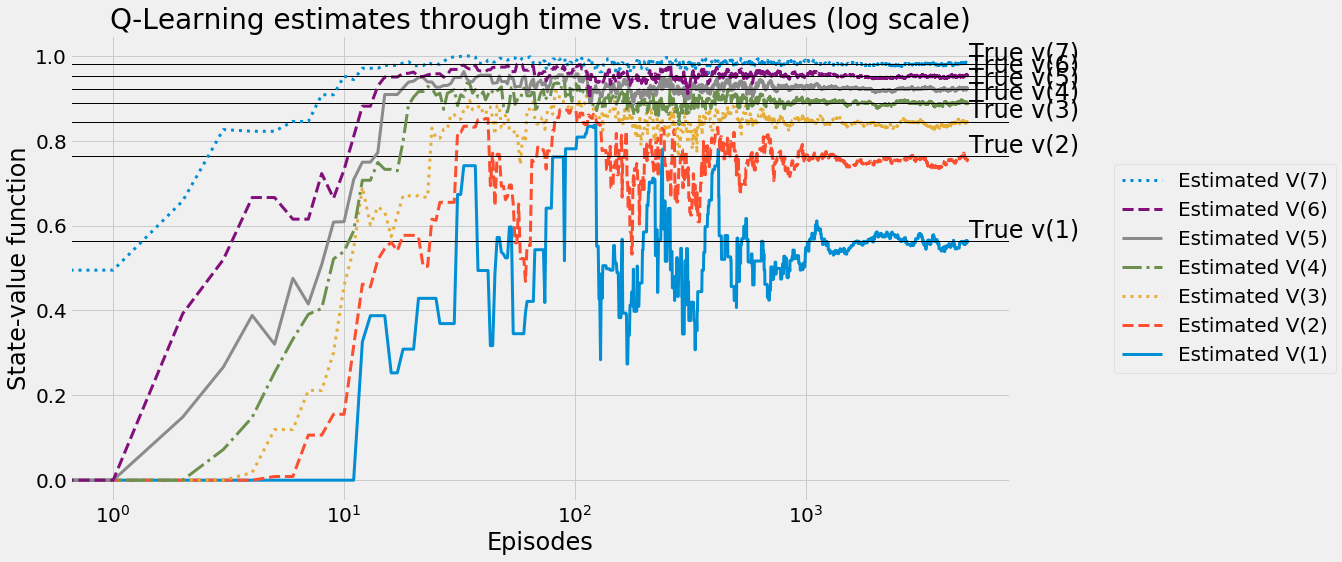

In [34]:
plot_value_function(
    'Q-Learning estimates through time vs. true values (log scale)', 
    np.max(Q_track_ql, axis=2), 
    optimal_V, 
    log=True)

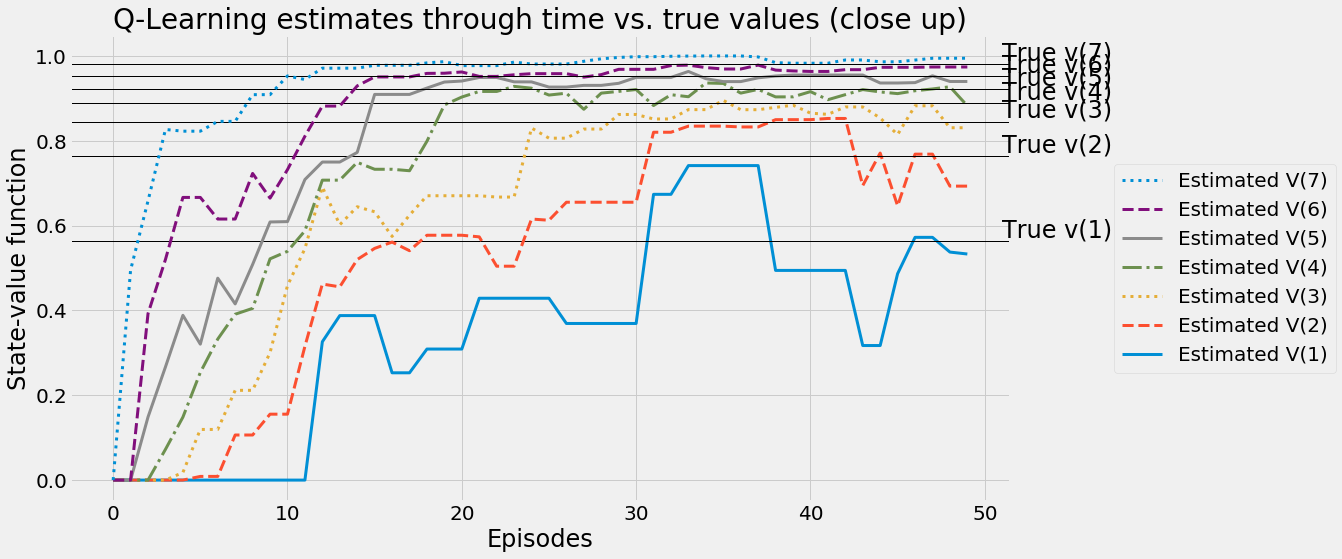

In [35]:
plot_value_function(
    'Q-Learning estimates through time vs. true values (close up)', 
    np.max(Q_track_ql, axis=2)[:50], 
    optimal_V[:50],
    log=False)

# Russell & Norvig's Gridworld

In [36]:
env = gym.make('RussellNorvigGridworld-v0')
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P)
print_state_value_function(optimal_V, P, n_cols=4, prec=4, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=4, 
                            title='Optimal action-value function:')
print()

print_policy(optimal_pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%. Obtains an average undiscounted return of {:.4f}.'.format(
    probability_success(env, optimal_pi, goal_state=3)*100, 
    mean_return(env, optimal_pi)))

Optimal state-value function:
| 00 0.8116 | 01 0.8678 | 02 0.9178 |           |
| 04 0.7616 |           | 06 0.6603 |           |
| 08 0.7053 | 09 0.6553 | 10 0.6114 | 11 0.3879 |

Optimal action-value function:
╒═════╤════════╤════════╤═════════╤═════════╕
│   s │      < │      v │       > │       ^ │
╞═════╪════════╪════════╪═════════╪═════════╡
│   0 │ 0.7666 │ 0.7372 │  0.8116 │  0.7772 │
├─────┼────────┼────────┼─────────┼─────────┤
│   1 │ 0.7828 │ 0.8272 │  0.8678 │  0.8272 │
├─────┼────────┼────────┼─────────┼─────────┤
│   2 │ 0.8121 │ 0.675  │  0.9178 │  0.881  │
├─────┼────────┼────────┼─────────┼─────────┤
│   3 │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼─────────┼─────────┤
│   4 │ 0.7209 │ 0.6766 │  0.7209 │  0.7616 │
├─────┼────────┼────────┼─────────┼─────────┤
│   5 │ 0      │ 0      │  0      │  0      │
├─────┼────────┼────────┼─────────┼─────────┤
│   6 │ 0.6411 │ 0.4152 │ -0.6871 │  0.6603 │
├─────┼────────┼────────┼─────────┼─────────┤
│   7 

In [37]:
Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = on_policy_mc_control(env)

In [38]:
print_state_value_function(V_mc, P, n_cols=4, prec=3, title='State-value function found by MC:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='MC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_mc, goal_state=3)*100))

State-value function found by MC:
| 00   0.75 | 01  0.816 | 02  0.883 |           |
| 04  0.669 |           | 06  0.605 |           |
| 08  0.589 | 09  0.429 | 10  0.359 | 11  0.035 |
Optimal state-value function:
| 00  0.812 | 01  0.868 | 02  0.918 |           |
| 04  0.762 |           | 06   0.66 |           |
| 08  0.705 | 09  0.655 | 10  0.611 | 11  0.388 |
State-value function errors:
| 00 -0.062 | 01 -0.052 | 02 -0.035 |           |
| 04 -0.093 |           | 06 -0.055 |           |
| 08 -0.117 | 09 -0.226 | 10 -0.252 | 11 -0.353 |
State-value function RMSE: 0.1508

MC action-value function:
╒═════╤═══════╤════════╤════════╤════════╤═══════╤═══════╤════════╤════════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │      v │      > │      ^ │   * < │   * v │    * > │    * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══════╪════════╪════════╪════════╪═══════╪═══════╪════════╪════════╪═════════╪═════════╪═════════╪═════════╡
│   0 │ 0.633 │  0.668 │  0.75  │  0.678 │ 0.

In [39]:
Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env)

In [40]:
print_state_value_function(V_sarsa, P, n_cols=4, prec=3, title='State-value function found by SARSA:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='SARSA action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_sarsa, goal_state=3)*100))

State-value function found by SARSA:
| 00  0.756 | 01  0.828 | 02  0.903 |           |
| 04   0.69 |           | 06  0.574 |           |
| 08  0.593 | 09  0.514 | 10  0.191 | 11 -0.491 |
Optimal state-value function:
| 00  0.812 | 01  0.868 | 02  0.918 |           |
| 04  0.762 |           | 06   0.66 |           |
| 08  0.705 | 09  0.655 | 10  0.611 | 11  0.388 |
State-value function errors:
| 00 -0.055 | 01  -0.04 | 02 -0.015 |           |
| 04 -0.072 |           | 06 -0.086 |           |
| 08 -0.112 | 09 -0.141 | 10  -0.42 | 11 -0.879 |
State-value function RMSE: 0.2886

SARSA action-value function:
╒═════╤════════╤════════╤════════╤════════╤═══════╤═══════╤════════╤════════╤═════════╤═════════╤═════════╤═════════╕
│   s │      < │      v │      > │      ^ │   * < │   * v │    * > │    * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪════════╪════════╪════════╪════════╪═══════╪═══════╪════════╪════════╪═════════╪═════════╪═════════╪═════════╡
│   0 │  0.615 │  0.561 │  0.756 │  

In [41]:
Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env)

In [42]:
print_state_value_function(V_ql, P, n_cols=4, prec=3, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_ql, goal_state=3)*100))

State-value function found by Q-learning:
| 00  0.816 | 01  0.871 | 02  0.914 |           |
| 04  0.766 |           | 06  0.666 |           |
| 08  0.706 | 09  0.654 | 10  0.622 | 11   0.49 |
Optimal state-value function:
| 00  0.812 | 01  0.868 | 02  0.918 |           |
| 04  0.762 |           | 06   0.66 |           |
| 08  0.705 | 09  0.655 | 10  0.611 | 11  0.388 |
State-value function errors:
| 00  0.004 | 01  0.003 | 02 -0.004 |           |
| 04  0.004 |           | 06  0.005 |           |
| 08  0.001 | 09 -0.002 | 10   0.01 | 11  0.102 |
State-value function RMSE: 0.0296

Q-learning action-value function:
╒═════╤═══════╤═══════╤════════╤════════╤═══════╤═══════╤════════╤════════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │      > │      ^ │   * < │   * v │    * > │    * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══════╪═══════╪════════╪════════╪═══════╪═══════╪════════╪════════╪═════════╪═════════╪═════════╪═════════╡
│   0 │ 0.771 │ 0.749 │  0.816 │

# FrozenLake environment

In [43]:
env = gym.make('FrozenLake-v0')
P = env.env.P

optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=0.99)
print_state_value_function(optimal_V, P, n_cols=4, prec=4, title='Optimal state-value function:')
print()

print_action_value_function(optimal_Q, 
                            None, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=4, 
                            title='Optimal action-value function:')
print()

print_policy(optimal_pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%. Obtains an average undiscounted return of {:.4f}.'.format(
    probability_success(env, optimal_pi, goal_state=15)*100, 
    mean_return(env, optimal_pi)))

Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |

Optimal action-value function:
╒═════╤════════╤════════╤════════╤════════╕
│   s │      < │      v │      > │      ^ │
╞═════╪════════╪════════╪════════╪════════╡
│   0 │ 0.542  │ 0.5278 │ 0.5278 │ 0.5223 │
├─────┼────────┼────────┼────────┼────────┤
│   1 │ 0.3435 │ 0.3342 │ 0.3199 │ 0.4988 │
├─────┼────────┼────────┼────────┼────────┤
│   2 │ 0.4382 │ 0.4336 │ 0.4243 │ 0.4707 │
├─────┼────────┼────────┼────────┼────────┤
│   3 │ 0.3061 │ 0.3061 │ 0.3015 │ 0.4569 │
├─────┼────────┼────────┼────────┼────────┤
│   4 │ 0.5585 │ 0.3796 │ 0.3742 │ 0.3632 │
├─────┼────────┼────────┼────────┼────────┤
│   5 │ 0      │ 0      │ 0      │ 0      │
├─────┼────────┼────────┼────────┼────────┤
│   6 │ 0.3583 │ 0.203  │ 0.3583 │ 0.1553 │
├─────┼────────┼────────┼────────┼

In [44]:
Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = on_policy_mc_control(env, gamma=0.99, n_episodes=20000)

In [45]:
print_state_value_function(V_mc, P, n_cols=4, prec=3, title='State-value function found by MC:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='MC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_mc, goal_state=15)*100))

State-value function found by MC:
| 00  0.282 | 01  0.208 | 02  0.184 | 03  0.169 |
| 04  0.304 |           | 06  0.197 |           |
| 08  0.347 | 09  0.437 | 10  0.442 |           |
|           | 13  0.578 | 14  0.767 |           |
Optimal state-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |
State-value function errors:
| 00  -0.26 | 01  -0.29 | 02 -0.287 | 03 -0.288 |
| 04 -0.255 |           | 06 -0.161 |           |
| 08 -0.245 | 09 -0.206 | 10 -0.174 |           |
|           | 13 -0.163 | 14 -0.096 |           |
State-value function RMSE: 0.1898

MC action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══════╪═══════

In [46]:
Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env, gamma=0.99, n_episodes=20000)

In [47]:
print_state_value_function(V_sarsa, P, n_cols=4, prec=3, title='State-value function found by SARSA:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='SARSA action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_sarsa, goal_state=15)*100))

State-value function found by SARSA:
| 00  0.294 | 01  0.235 | 02  0.211 | 03  0.139 |
| 04   0.32 |           | 06  0.207 |           |
| 08  0.369 | 09  0.463 | 10   0.48 |           |
|           | 13  0.595 | 14  0.823 |           |
Optimal state-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |
State-value function errors:
| 00 -0.248 | 01 -0.263 | 02 -0.259 | 03 -0.318 |
| 04 -0.238 |           | 06 -0.151 |           |
| 08 -0.223 | 09  -0.18 | 10 -0.136 |           |
|           | 13 -0.147 | 14 -0.039 |           |
State-value function RMSE: 0.1772

SARSA action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪═══════╪═

In [48]:
Q_ql, V_ql, pi_ql, Q_track_ql, pi_track_ql = q_learning(env, gamma=0.99, n_episodes=20000)

In [49]:
print_state_value_function(V_ql, P, n_cols=4, prec=3, title='State-value function found by Q-learning:')
print_state_value_function(optimal_V, P, n_cols=4, prec=3, title='Optimal state-value function:')
print_state_value_function(V_ql - optimal_V, P, n_cols=4, prec=3, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_ql, optimal_V)))
print()
print_action_value_function(Q_ql, 
                            optimal_Q, 
                            action_symbols=('<', 'v', '>', '^'), 
                            prec=3, 
                            title='Q-learning action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_ql, optimal_Q)))
print()
print_policy(pi_ql, P, action_symbols=('<', 'v', '>', '^'), n_cols=4)
print('Reaches goal {:.2f}%.'.format(probability_success(env, pi_ql, goal_state=15)*100))

State-value function found by Q-learning:
| 00  0.518 | 01   0.47 | 02  0.438 | 03  0.426 |
| 04  0.535 |           | 06  0.304 |           |
| 08  0.575 | 09  0.625 | 10  0.604 |           |
|           | 13  0.735 | 14  0.858 |           |
Optimal state-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |
State-value function errors:
| 00 -0.024 | 01 -0.029 | 02 -0.032 | 03 -0.031 |
| 04 -0.024 |           | 06 -0.054 |           |
| 08 -0.017 | 09 -0.018 | 10 -0.012 |           |
|           | 13 -0.007 | 14 -0.005 |           |
State-value function RMSE: 0.022

Q-learning action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   err v │   err > │   err ^ │
╞═════╪

# Policy evolution comparison

In [50]:
mc_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=15, iterations=10)*100 for pi in tqdm(pi_track_mc)])

In [51]:
sarsa_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=15, iterations=10)*100 for pi in tqdm(pi_track_sarsa)])

In [52]:
ql_success_evolution = moving_average([probability_success(
    env, lambda s: pi[s], goal_state=15, iterations=10)*100 for pi in tqdm(pi_track_ql)])

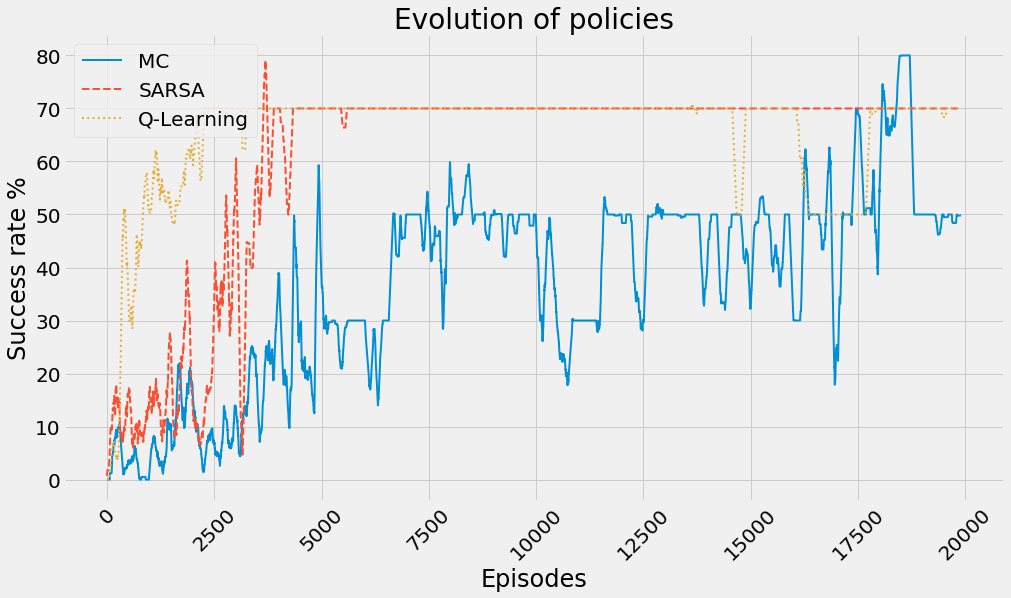

In [53]:
plt.plot(mc_success_evolution, '-', linewidth=2, label='MC')
plt.plot(sarsa_success_evolution, '--', linewidth=2, label='SARSA')
plt.plot(ql_success_evolution, ':', linewidth=2, label='Q-Learning')
plt.legend(loc=2, ncol=1)

plt.title('Evolution of policies')
plt.xlabel('Episodes')
plt.ylabel('Success rate %')
plt.xticks(rotation=45)

plt.show()

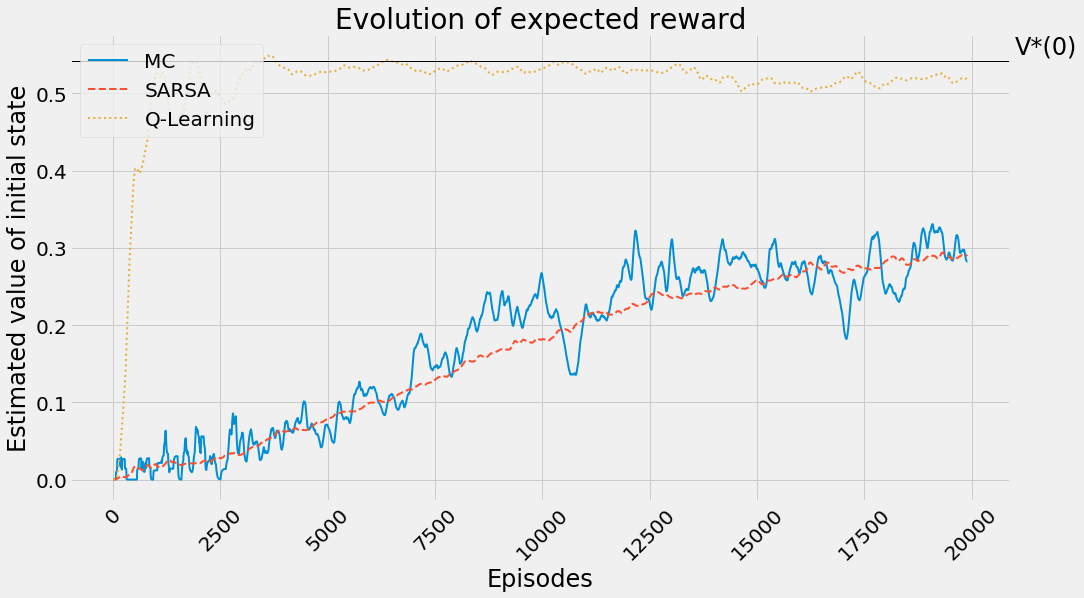

In [54]:
plt.plot(moving_average(np.max(Q_track_mc, axis=2).T[0]), 
         '-', linewidth=2, label='MC')
plt.plot(moving_average(np.max(Q_track_sarsa, axis=2).T[0]), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.max(Q_track_ql, axis=2).T[0]), 
         ':', linewidth=2, label='Q-Learning')
plt.legend(loc=2, ncol=1)

plt.axhline(y=optimal_V[0], color='k', linestyle='-', linewidth=1)
plt.text(int(len(Q_track_mc)*1.05), optimal_V[0]+.01, 'V*(0)')


plt.title('Evolution of expected reward')
plt.xlabel('Episodes')
plt.ylabel('Estimated value of initial state')
plt.xticks(rotation=45)

plt.show()

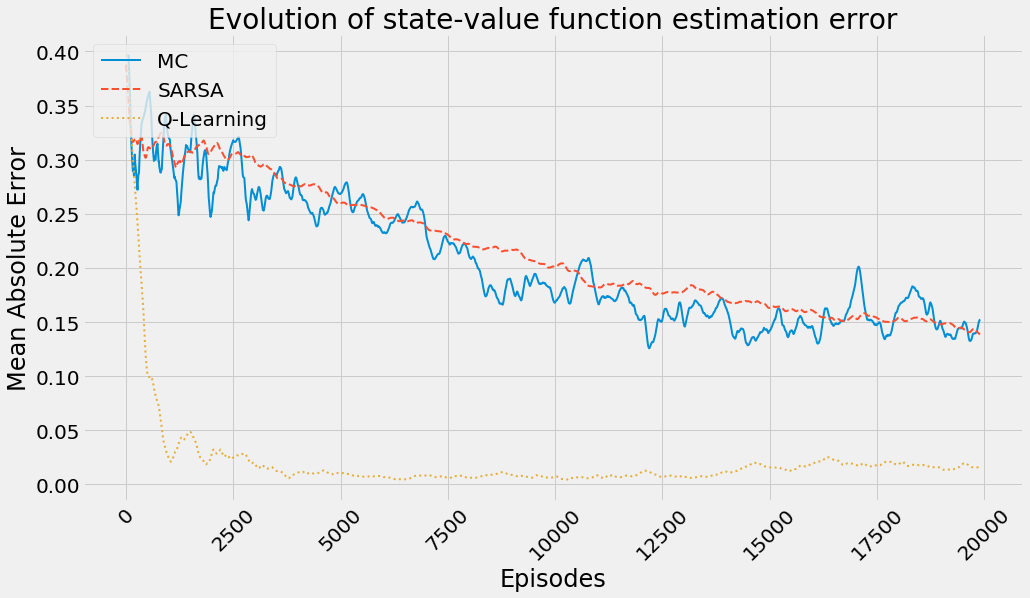

In [55]:
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_mc, axis=2) - optimal_V), axis=1)), 
         '-', linewidth=2, label='MC')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_sarsa, axis=2) - optimal_V), axis=1)), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.mean(np.abs(np.max(Q_track_ql, axis=2) - optimal_V), axis=1)), 
         ':', linewidth=2, label='Q-Learning')
plt.legend(loc=2, ncol=1)

plt.title('Evolution of state-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

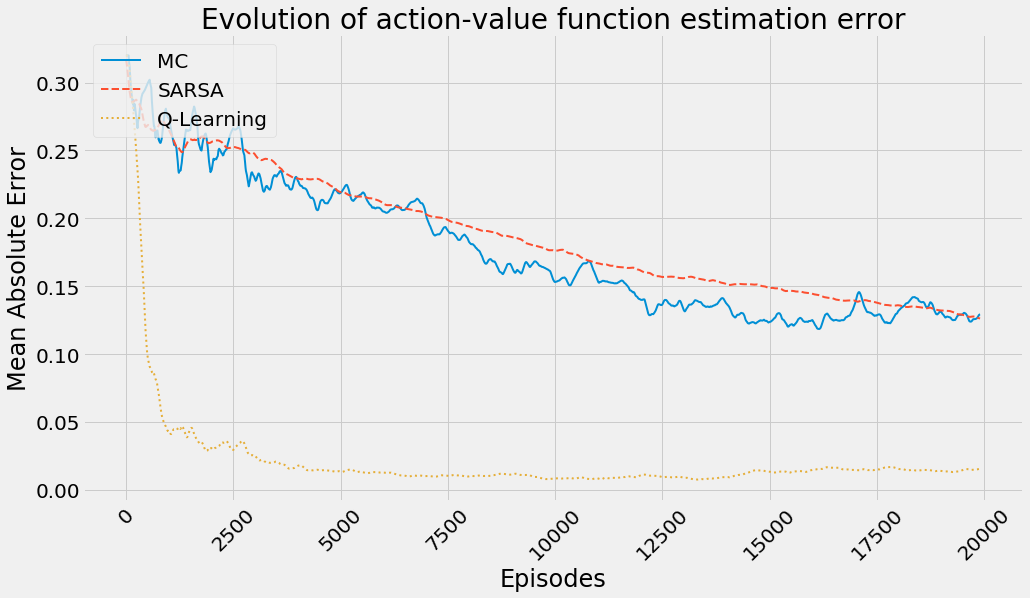

In [56]:
plt.plot(moving_average(np.mean(np.abs(Q_track_mc - optimal_Q), axis=(1,2))), 
         '-', linewidth=2, label='MC')
plt.plot(moving_average(np.mean(np.abs(Q_track_sarsa - optimal_Q), axis=(1,2))), 
         '--', linewidth=2, label='SARSA')
plt.plot(moving_average(np.mean(np.abs(Q_track_ql - optimal_Q), axis=(1,2))), 
         ':', linewidth=2, label='Q-Learning')
plt.legend(loc=2, ncol=1)

plt.title('Evolution of action-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.show()

In [57]:
mc_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_mc)])

In [58]:
sarsa_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_sarsa)])

In [59]:
ql_regret_accumulation = moving_average([regret_accumulation(
    env, lambda s: pi[s], optimal_Q, iterations=10) for pi in tqdm(pi_track_ql)])

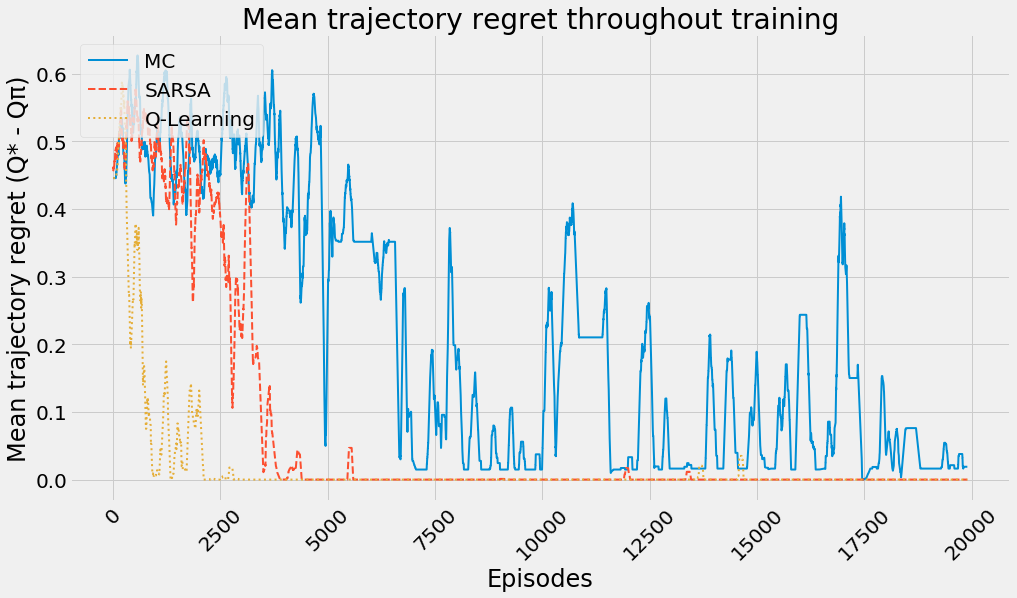

In [60]:
plt.plot(mc_regret_accumulation, '-', linewidth=2, label='MC')
plt.plot(sarsa_regret_accumulation, '--', linewidth=2, label='SARSA')
plt.plot(ql_regret_accumulation, ':', linewidth=2, label='Q-Learning')
plt.legend(loc=2, ncol=1)

plt.title('Mean trajectory regret throughout training')
plt.xlabel('Episodes')
plt.ylabel('Mean trajectory regret (Q* - Qπ)')
plt.xticks(rotation=45)

plt.show()

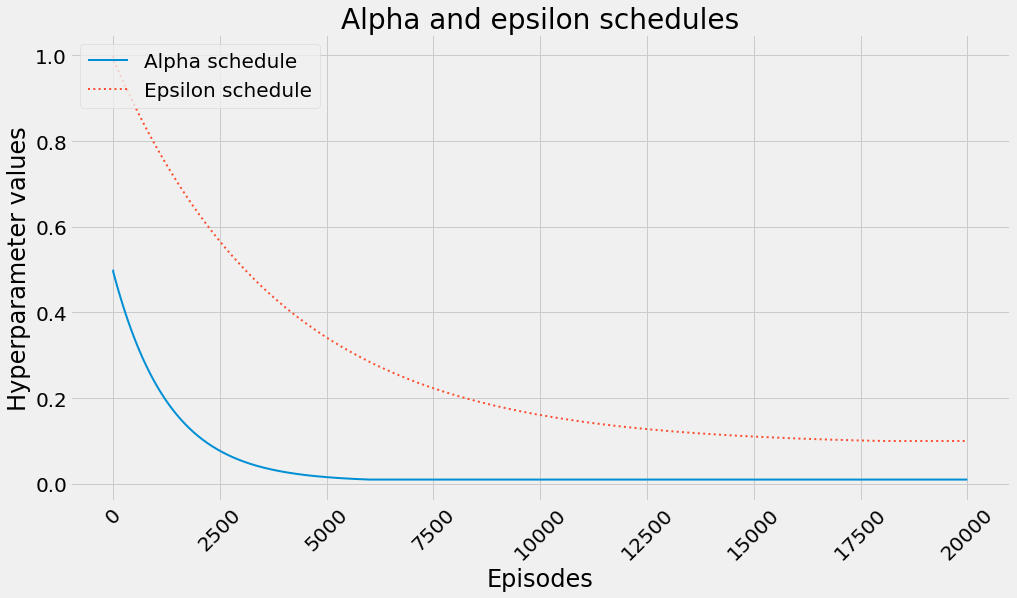

In [61]:
plt.plot([decay_schedule(0.5, 0.01, 0.3, 20000, i) for i in range(20000)], '-', linewidth=2, label='Alpha schedule')
plt.plot([decay_schedule(1.0, 0.1, 0.9, 20000, i) for i in range(20000)], ':', linewidth=2, label='Epsilon schedule')
plt.legend(loc=2, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()